In [2]:
import numpy as np
import numba
import random
import matplotlib.pyplot as plt
import scipy.integrate

import seaborn as sns
sns.set(font_scale = 1.5, rc={"lines.linewidth":2})

## Problem 1

Due to the random nature of a stochastic process, a single simulation may not be representative. To get a better sense of how this system will behave *on average*, use a `for` loop to repeat our stochastic simulation 100 times. Plot each of these simulations on the same plot to see how much variability there can be from simulation to simulation. Remember you can use the `alpha` variable to make your plots more transparent and easier to visualize many on top of each other.

In [3]:
# specifying the parameters
beta = 10 # per min
gamma = 1 # per min, per transcript

# how long we want run simulation for
total_time = 10 # mins

def gillespie():

    # initializing the number of mRNAs and the time
    m = [1]
    t = [0]

    while t[-1] < total_time:

        # specify the propensities for the possible state change
        production_prop = beta 
        degradation_prop = gamma * m[-1]

        # add up all the propensities
        total_prop = production_prop + degradation_prop 

        # determine how much time elapses before "something" happens
        time_elapsed = np.random.exponential(1/total_prop)

        # update time array 
        t.append( t[-1] + time_elapsed )

        # randomly choose which event happens. weighted by their propensities
        event = random.choices(["production", "degradation"], 
                               weights=(production_prop, degradation_prop))[0]

        # update mRNA list based on which event happend
        if event == "production":
            m.append( m[-1] + 1 )

        if event == "degradation":
            m.append( m[-1] - 1 )
    
    plt.plot(t, m, color="k", alpha=0.1)

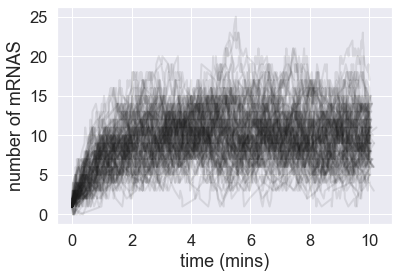

In [5]:
for i in range(100):
    gillespie()

plt.xlabel("time (mins)")
plt.ylabel("number of mRNAS");

## Problem 2

Numerically integrate the $ \frac{\mathrm{d}m}{\mathrm{d}t} = \beta_m - \gamma_m m$ differential equation, using one of our previous methods (Euler, `scipy`, etc.). Plot the results of your numerical integration on top of your stochastic simulations from Problem 2. How do the results compare?

In [6]:
def rhs(x, t, beta, gamma):
    """
    Right hand side for logistic growth.
    Looking at two population silumtaneously 
    """
    # Compute dx/dt
    dx_dt =  beta - gamma*x

    # Return the result as a NumPy array
    return np.array(dx_dt)

In [7]:
# Time points we want for the solution
t = np.linspace(0,10,1000)

# Initial conditions
x_0 = np.array([1])

# Package parameters into a tuple
args = (beta, gamma)

# Integrate ODES
x = scipy.integrate.odeint(rhs, x_0, t, args=args)

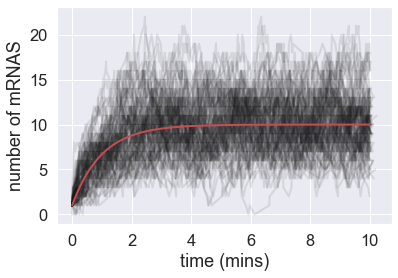

In [8]:
for i in range(100):
    gillespie()

plt.xlabel("time (mins)")
plt.ylabel("number of mRNAS")

plt.plot(t, x, color="r");

The numerical integration (red line) seems to well represent the average behavior of the stochastic simulations. 

## Problem 3

Expand our simulation from class to now keep track of both an mRNA and protein populations.

\begin{align}
\begin{array}{ll}
\text{reaction, }r_i & \text{propensity, } a_i \\
m \rightarrow m+1,\;\;\;\; & \beta_m \\[0.3em]
m \rightarrow m-1, \;\;\;\; & \gamma_m m\\[0.3em]
p \rightarrow p+1, \;\;\;\; & \beta_p m \\[0.3em]
p \rightarrow p-1, \;\;\;\; & \gamma_p p.
\end{array}
\end{align}

Below I specify the parameters you should use for this simulation. Since the number of mRNAs and the number of proteins are substantially different, plot their trajectories over time on separate plots. 

In [9]:
# specifying the parameters
beta_m = 10 # per min
gamma_m = 1 # per min, per transcript
beta_p = 10 # per min
gamma_p = 0.5 # per min, per protein

# how long we want run simulation for
total_time = 20 # mins

def gillespie():
    
    # initializing the number of mRNAs and the time
    m = [1]
    p = [1]
    t = [0]

    while t[-1] < total_time:

        # specify the propensities for the possible state change
        m_production_rate = beta_m
        m_degradation_rate = m[-1] * gamma_m
        p_production_rate = beta_p * m[-1]
        p_degradation_rate = p[-1] * gamma_p

        # add up all the propensities
        total_rate = m_production_rate + m_degradation_rate + p_production_rate + p_degradation_rate

        # determine how much time elapses before "something+ happens
        time_elapsed = np.random.exponential(1/total_rate)

        # update time array 
        t.append(t[-1] + time_elapsed)

        # randomly choose which event happens
        event = random.choices(["m production", "m degradation", "p production", "p degradation"], 
                               weights=(m_production_rate, m_degradation_rate,
                                        p_production_rate, p_degradation_rate,))[0]

        # update mRNA list based on which event happend
        if event == "m production":
            m.append(m[-1]+1)
            p.append(p[-1])

        if event == "m degradation":
            m.append(m[-1]-1)
            p.append(p[-1])

        if event == "p production":
            p.append(p[-1]+1)
            m.append(m[-1])

        if event == "p degradation":
            p.append(p[-1]-1)
            m.append(m[-1])
            
    return t, m, p

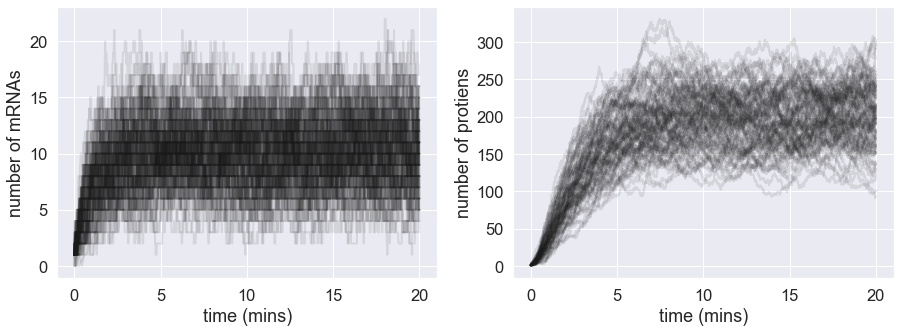

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15,5), sharex=True)

for i in range(100):
    t, m, p = gillespie()
    
    ax[0].plot(t, m, color="k", alpha=0.1)
    ax[1].plot(t, p, color="k", alpha=0.1)
    
ax[0].set_xlabel("time (mins)")
ax[0].set_ylabel("number of mRNAs")

ax[1].set_xlabel("time (mins)")
ax[1].set_ylabel("number of protiens");

## Problem 4

Returning to the original equations, what are the expected steady-state / fixed point values for the number of mRNAs and proteins? Calculate precise numbers based on the parameter values we've used here. How do these expected value compare to what you see in your simulation?

The steady state for mRNA should be $\beta_m / \gamma_m$, which equals 10 with these parameters. We see in the left plot that the number of mRNAs do in fact fluctuate around that value of 10.

The steady state for protein should be $\beta_m \beta_p / \gamma_m \gamma_p$, which equals 200 with these parameters. Again, the simulations (on the right this time) seem to settle on values near this expected fixed point.